## Querying historical MTHexapod data

In [1]:
import pandas as pd
from string import Template
from lsst_efd_client import EfdClient

## July 2022

USDF has a database with the EFD historical data until August 2022. So you can query July 2022 data using:

In [2]:
client = EfdClient("usdf_efd", db_name="efd-s2022-08-10")

In [3]:
# Query MTHexapod heartbeats

start = '2022-07-01'
end = '2022-07-31'
query = f'''SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '{start}' AND time < '{end}' GROUP BY time(1h) '''
heartbeats = await client.influx_client.query(query)


<AxesSubplot: >

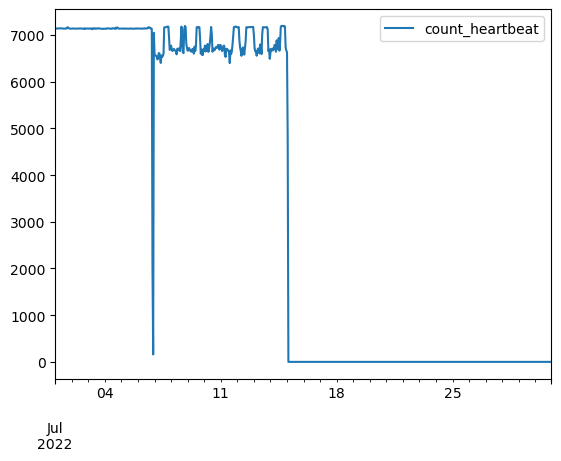

In [4]:
heartbeats.plot(y="count_heartbeat")

In [5]:
# Query MTHexapod actuators data (salIndex=1 means means Camera Hexapod)

start = '2022-07-01'
end = '2022-07-31'
query = f'''SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM  "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '{start}' AND time < '{end}' '''
actuators = await client.influx_client.query(query)


<AxesSubplot: >

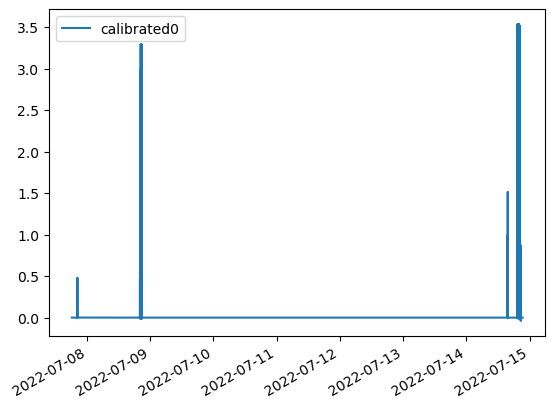

In [6]:
actuators.plot(y="calibrated0")

In [7]:
actuators[actuators['calibrated0']>0]

,calibrated0,calibrated1,calibrated2,calibrated3,calibrated4,calibrated5
2022-07-07 20:23:27.269000+00:00,0.481027,0.065493,0.480999,0.065623,0.480954,0.065675
2022-07-07 20:23:27.319000+00:00,0.481027,0.065493,0.480999,0.065623,0.480954,0.065675
2022-07-07 20:23:37.023000+00:00,0.065493,0.481027,0.065675,0.480954,0.065623,0.480999
2022-07-07 20:23:37.074000+00:00,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819
2022-07-07 20:23:37.124000+00:00,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819
...,...,...,...,...,...,...
2022-07-14 20:36:14.471000+00:00,0.288465,0.678138,0.288657,0.678059,0.288578,0.678126
2022-07-14 20:36:24.625000+00:00,0.631554,0.892713,0.631721,0.892646,0.631615,0.892741
2022-07-14 20:36:34.778000+00:00,0.868225,0.952096,0.868347,0.952061,0.868232,0.952174
2022-07-14 20:36:34.828000+00:00,0.868225,0.952096,0.868347,0.952061,0.868232,0.952174


## August 2022
August 2022 data is restored at the Base EFD on a shard basis. That  means we have to query individual shards (a week worth of data) and concatenate the partial results.

For that we need to map the shards and their database:

In [8]:
august2022 = [
    {"db_name": "efd-s1071", "start": "2022-08-08", "end": "2022-08-15"},
    {"db_name": "efd-s1078", "start": "2022-08-15", "end": "2022-08-22"},
    {"db_name": "efd-s1088", "start": "2022-08-22", "end": "2022-08-29"}
]

We also need this helper function:

In [9]:
async def query_shards(period, query):

    df = pd.Series()
    
    for shard in period:

        client = EfdClient("summit_efd_copy", db_name=shard["db_name"])
        q = query.substitute(start=shard["start"], end=shard["end"])
        print(f"DEBUG: {q}")
        partial = await client.influx_client.query(q)
        
        if type(partial) is not dict:
            df = pd.concat([df, partial])
        
    return df

And a template query that has the `start` and `end` variables. 

In [10]:
# Query MTHexapod heartbeats

query = Template('''SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '$start' AND time < '$end' GROUP BY time(1h) ''')
heartbeats = await query_shards(august2022, query)

DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-08-08' AND time < '2022-08-15' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-08-15' AND time < '2022-08-22' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-08-22' AND time < '2022-08-29' GROUP BY time(1h) 


<AxesSubplot: >

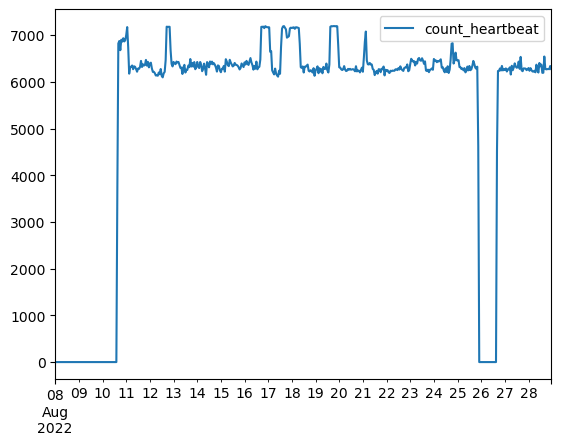

In [11]:
heartbeats.plot(y="count_heartbeat")

In [12]:
# Query MTHexapod actuators data (salIndex=1 means means Camera Hexapod)

query = Template('''SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrate5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '$start' AND time < '$end' ''')
actuators = await query_shards(august2022, query)

DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrate5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-08-08' AND time < '2022-08-15' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrate5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-08-15' AND time < '2022-08-22' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrate5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-08-22' AND time < '2022-08-29' 


<AxesSubplot: >

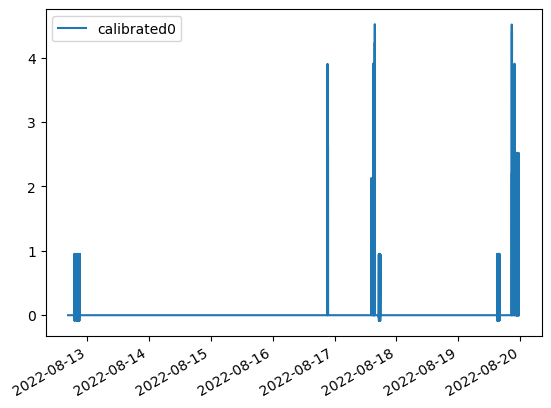

In [13]:
actuators.plot(y="calibrated0")

### September 2022
September 2022 data is also restored at the Base EFD on a shard basis. 

In [14]:
september2022 = [
    {"db_name": "efd-s597", "start": "2022-08-29", "end": "2022-09-05"},
    {"db_name": "efd-s602", "start": "2022-09-05", "end": "2022-09-12"},
    {"db_name": "efd-s921", "start": "2022-09-12", "end": "2022-09-19"},
    {"db_name": "efd-s932", "start": "2022-09-19", "end": "2022-09-26"},
    {"db_name": "efd-s943", "start": "2022-09-26", "end": "2022-10-03"}
]

In [15]:
# Query MTHexapod heartbeats

query = Template('''SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '$start' AND time < '$end' GROUP BY time(1h) ''')

heartbeats = await query_shards(september2022, query)

DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-08-29' AND time < '2022-09-05' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-09-05' AND time < '2022-09-12' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-09-12' AND time < '2022-09-19' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-09-19' AND time < '2022-09-26' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-09-26' AND time < '2022-10-03' GROUP BY time(1h) 


<AxesSubplot: >

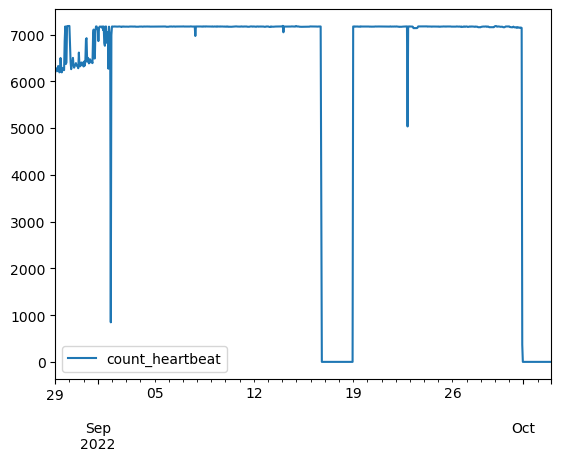

In [16]:
heartbeats.plot(y="count_heartbeat")

In [17]:
# Query MTHexapod actuators data (salIndex=1 means means Camera Hexapod)

query = Template('''SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '$start' AND time < '$end' ''')
actuators = await query_shards(september2022, query)

DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-08-29' AND time < '2022-09-05' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-09-05' AND time < '2022-09-12' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-09-12' AND time < '2022-09-19' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-09-19' AND time < '2022-09-26' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-09-26' 

<AxesSubplot: >

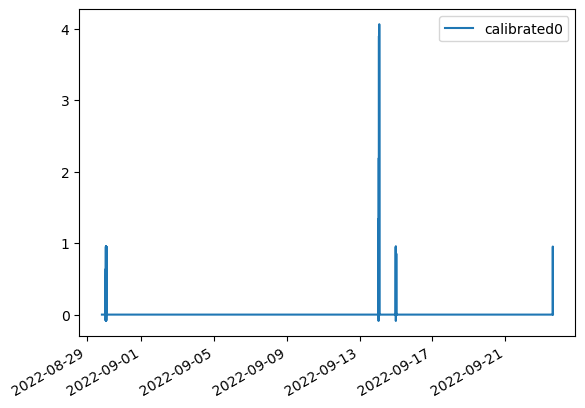

In [18]:
actuators.plot(y="calibrated0")

In [19]:
actuators[actuators['calibrated0']>0]

,0,calibrated0,calibrated1,calibrated2,calibrated3,calibrated4,calibrated5
2022-08-30 00:45:40.874000+00:00,NaN,0.255248,-0.080805,0.255215,-0.080705,0.255194,-0.080689
2022-08-30 00:45:40.925000+00:00,NaN,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
2022-08-30 00:45:40.974000+00:00,NaN,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
2022-08-30 00:45:41.025000+00:00,NaN,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
2022-08-30 00:45:41.075000+00:00,NaN,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
...,...,...,...,...,...,...,...
2022-09-23 14:48:39.800176+00:00,NaN,0.001229,0.001229,0.001229,0.001229,0.001229,0.001229
2022-09-23 14:48:39.850212+00:00,NaN,0.001229,0.001229,0.001229,0.001229,0.001229,0.001229
2022-09-23 14:48:39.900236+00:00,NaN,0.001229,0.001229,0.001229,0.001229,0.001229,0.001229
2022-09-23 14:48:49.054314+00:00,NaN,0.425072,0.775191,0.425258,0.775114,0.425168,0.775192


### October 2022
October 2022 data is also restored at the Base EFD on a shard basis. 

In [20]:
october2022 = [
    {"db_name": "efd-s987", "start": "2022-10-24", "end": "2022-10-31"},
    {"db_name": "efd-s976", "start": "2022-10-17", "end": "2022-10-24"},
    {"db_name": "efd-s965", "start": "2022-10-10", "end": "2022-10-17"},
    {"db_name": "efd-s954", "start": "2022-10-03", "end": "2022-10-10"}
]

In [21]:
# Query MTHexapod heartbeats

query = Template('''SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '$start' AND time < '$end' GROUP BY time(1h) ''')

heartbeats = await query_shards(october2022, query)

DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-10-24' AND time < '2022-10-31' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-10-17' AND time < '2022-10-24' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-10-10' AND time < '2022-10-17' GROUP BY time(1h) 
DEBUG: SELECT count("heartbeat") AS "count_heartbeat" FROM "lsst.sal.MTHexapod.logevent_heartbeat" WHERE time > '2022-10-03' AND time < '2022-10-10' GROUP BY time(1h) 


<AxesSubplot: >

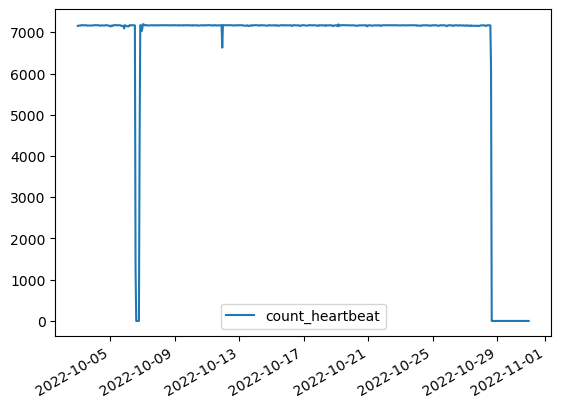

In [22]:
heartbeats.plot(y="count_heartbeat")

In [23]:
# Query MTHexapod actuators data (salIndex=1 means means Camera Hexapod)

query = Template('''SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '$start' AND time < '$end' ''')
actuators = await query_shards(october2022, query)

DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-10-24' AND time < '2022-10-31' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-10-17' AND time < '2022-10-24' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-10-10' AND time < '2022-10-17' 
DEBUG: SELECT "calibrated0", "calibrated1", "calibrated2", "calibrated3", "calibrated4", "calibrated5" FROM "lsst.sal.MTHexapod.actuators" WHERE salIndex=1 AND time > '2022-10-03' AND time < '2022-10-10' 


<AxesSubplot: >

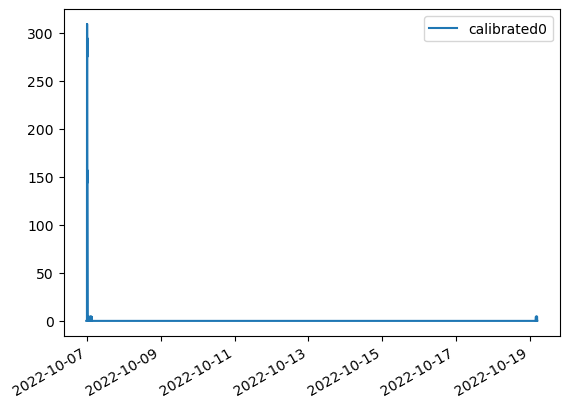

In [24]:
actuators.plot(y="calibrated0")

In [25]:
actuators[actuators['calibrated0']>0]

,0,calibrated0,calibrated1,calibrated2,calibrated3,calibrated4,calibrated5
2022-10-19 04:00:10.766896+00:00,NaN,3.825292,4.130326,4.359543,4.107046,3.559543,3.452995
2022-10-19 04:00:10.816918+00:00,NaN,3.825292,4.130326,4.359543,4.107046,3.559543,3.452995
2022-10-19 04:00:48.128394+00:00,NaN,4.210593,3.759651,3.548286,3.888097,4.281320,4.444285
2022-10-19 04:01:07.935401+00:00,NaN,4.153657,4.331902,4.458226,4.384995,4.083617,3.951946
2022-10-19 04:01:08.485628+00:00,NaN,3.921726,4.299562,4.486581,4.313197,3.850289,3.598108
...,...,...,...,...,...,...,...
2022-10-07 02:57:27.487324+00:00,NaN,1.105275,1.437874,0.986102,1.222754,0.921739,0.489561
2022-10-07 02:58:09.553043+00:00,NaN,2.198832,1.544365,0.717795,1.150080,1.800031,1.830190
2022-10-07 02:58:23.658471+00:00,NaN,2.778736,2.052061,1.112140,1.411552,2.198430,2.448666
2022-10-07 02:58:23.708569+00:00,NaN,2.778736,2.052061,1.112140,1.411552,2.198430,2.448666
